<a href="https://colab.research.google.com/github/TimStep/QManifold/blob/main/QManifold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qiskit
!pip install -q pylatexenc #for mpl output
!pip install -q qiskit-machine-learning
#!pip install -q sparse
!pip install -q pennylane --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.

In [2]:
#default imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#QML imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.connectors import TorchConnector
import pennylane as qml

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Dataset

In [4]:
[ds] = qml.data.load("other", name = "hidden-manifold")

In [5]:
def to_dataset(ds):
  HMtrainX = []
  HMtrainY = []
  HMtestX = []
  HMtestY = []
  for m in ds.train:
    HMtrainX += ds.train[m]['inputs']
    HMtrainY += ds.train[m]['labels']
    HMtestX = ds.test[m]['inputs']
    HMtestY = ds.test[m]['labels']
  return np.array(HMtrainX), np.array(HMtrainY), np.array(HMtestX), np.array(HMtestY)

In [6]:
HMtrainX, HMtrainY, HMtestX, HMtestY = to_dataset(ds)
HMtrainX.shape, HMtrainY.shape, HMtestX.shape, HMtestY.shape

((4560, 10), (4560,), (60, 10), (60,))

In [7]:
class ManifoldDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.X = torch.tensor(data_x.astype('float32'))
        self.y = torch.tensor(data_y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [8]:
HMtrainDS = ManifoldDataset(HMtrainX, HMtrainY)
HMtestDS = ManifoldDataset(HMtestX, HMtestY)
HMtrainDL = DataLoader(HMtrainDS, shuffle=True, drop_last=True, pin_memory=True, batch_size = 1)
HMtestDL = DataLoader(HMtestDS, shuffle=False)

# PQN

In [9]:
class PQN():

    def __init__(self, qubits, repetitions, inputs=None, weights=None, input_gradients=False):

        if inputs is not None and len(inputs) != qubits:
          raise ValueError('Number of inputs doesnt align with number of qubits')

        self.qubits = qubits
        self.reps = repetitions

        self.weights = weights
        self.inputs = inputs
        self.gen_params()
        self.circuit = None
        self.gen_circuit()

        if self.weights is None or self.inputs is None or self.circuit is None:
          raise AttributeError('Weights, inputs or circuit is None')

    def gen_params(self):
      self.inputs = [Parameter("input" + str(i)) for i in range(1, self.qubits+1)] if self.inputs is None else self.inputs
      self.weights = [[Parameter("weight" + str(j) + str(i)) for i in range(1, 3*self.reps+1)] for j in range(1, self.qubits+1)] if self.weights is None else self.weights

    def gen_circuit(self):
      qc = QuantumCircuit(self.qubits)

      #encoding
      for q in range(self.qubits):
        qc.rx(self.inputs[q], q)

      for r in range(self.reps):
        #weighed gates
        for q in range(self.qubits):
          qc.rz(self.weights[q][r*3], q)
          qc.ry(self.weights[q][r*3+1], q)
          qc.rz(self.weights[q][r*3+2], q)

        #cnot gates
        for q in range(self.qubits-1):
          qc.cx(q, q+1)
        qc.cx(self.qubits-1, 0)

      self.circuit = qc

    def create_qnn(self):
      observables = []
      for q in range(self.qubits):
        s = ['I']*self.qubits
        s[q] = 'Y'
        observables.append(SparsePauliOp(''.join(s)))

      return EstimatorQNN(
          circuit=self.circuit,
          input_params=self.inputs,
          weight_params=list(np.array(self.weights).flatten()),
          observables=observables,
          input_gradients=True
      )



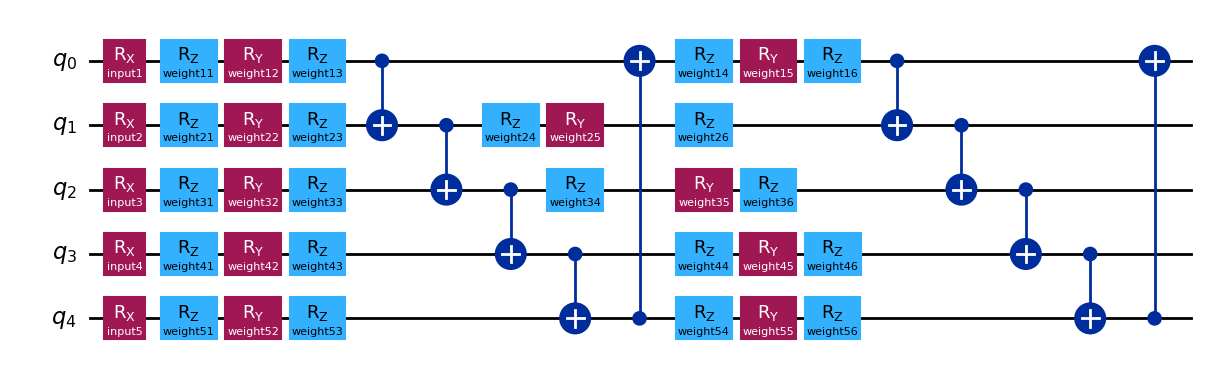

In [10]:
pqn = PQN(
    qubits=5, repetitions=2
)
pqnn = pqn.create_qnn()
pqnn.circuit.draw(output="mpl")

In [11]:
pqnn.forward(algorithm_globals.random.random(pqnn.num_inputs), algorithm_globals.random.random(pqnn.num_weights))

array([[ 0.01308069,  0.22693088,  0.04921432, -0.09675846,  0.06895598]])

In [12]:
tch_pqnn = TorchConnector(pqnn)

In [13]:
t = torch.tensor(algorithm_globals.random.random(pqnn.num_inputs))

In [14]:
tch_pqnn.forward(t)

tensor([ 0.0998,  0.0640,  0.1184,  0.0294, -0.0479],
       grad_fn=<_TorchNNFunctionBackward>)

In [15]:
tch_pqnn(t)

tensor([ 0.0998,  0.0640,  0.1184,  0.0294, -0.0479],
       grad_fn=<_TorchNNFunctionBackward>)

In [16]:
pqnn.num_weights

30

In [17]:
class HPQN(nn.Module):

  def __init__(self, input_size, layer_sizes=[5, 2, 1], qubits=5, repetitions=1, num_qlayers=1):
    super().__init__()

    #quantum layers
    pqn = PQN(
      qubits=qubits, repetitions=repetitions
    )
    self.qnn = []
    for i in range(num_qlayers):
      self.qnn.append(TorchConnector(pqn.create_qnn()))

    #FCNN before quantum layer
    self.preqNet = nn.Sequential(
        nn.Linear(input_size, qubits*num_qlayers),
        nn.ReLU()
    )

    #FCNN after quantum layer
    layers = [nn.Linear(qubits*num_qlayers, layer_sizes[0])]
    for l in range(len(layer_sizes)-1):
      layers.append(nn.ReLU())
      layers.append(nn.Linear(layer_sizes[l], layer_sizes[l+1]))
    self.postqNet = nn.Sequential(*layers)

  def forward(self, x):
    x = self.preqNet(x)
    xs = torch.split(x, self.qnn[0].neural_network.num_inputs)
    x = []
    for c in range(len(xs)):
      x.append(self.qnn[c](xs[c]))
    x = torch.concat(x)
    x = self.postqNet(x)
    return x

In [18]:
hqnn = HPQN(
    input_size=10
)
hqnn.to(device)

HPQN(
  (preqNet): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
  )
  (postqNet): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [22]:
criterion = nn.L1Loss(reduction='none')
optimizer = torch.optim.AdamW(hqnn.parameters(), lr=0.001, betas = (0.9, 0.99))

In [30]:
out = hqnn(HMtrainDS[1][0])
loss = criterion(out, HMtrainDS[1][1])
print(hqnn.parameters)
loss.backward()
optimizer.step()
print(hqnn.parameters)

<bound method Module.parameters of HPQN(
  (preqNet): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
  )
  (postqNet): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)>
<bound method Module.parameters of HPQN(
  (preqNet): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
  )
  (postqNet): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)>


# Train Loop

In [27]:
def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_relerr_arr = np.zeros(num_epochs)
    test_relerr_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        train_loss = 0
        test_loss = 0

        train_relative_error = 0
        test_relative_error = 0

        # train step
        model.train()
        for batch in train_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            # model forward-pass
            preds = model(X)

            # model backward-pass
            optimizer.zero_grad() # t.grad = torch.tensor([0., 0., 0.])
            loss = criterion(preds, y)
            loss_relative = (loss/y).mean()
            loss_mean = loss.mean()
            #loss_mean.backward()
            loss.backward()
            optimizer.step()

            # save loss and accuracy
            train_loss += loss_mean.detach().cpu().numpy()
            train_relative_error += loss_relative.detach().cpu().numpy()

        train_loss /= len(train_dataloader)
        train_relative_error /= len(train_dataloader)
        train_losses[i_epoch] = train_loss
        train_relerr_arr[i_epoch] = train_relative_error

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            with torch.no_grad():
                # model forward-pass
                preds = model(X)
                loss = criterion(preds, y)
                loss_mean = loss.mean()

                # save loss and accuracy
                test_loss += loss_mean.detach().cpu().numpy()
                test_relative_error += (loss.detach().cpu().numpy()/y.cpu().numpy()).mean()


        test_loss /= len(test_dataloader)
        test_relative_error /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_relerr_arr[i_epoch] = test_relative_error

    return train_losses, test_losses, train_relerr_arr, test_relerr_arr

In [28]:
num_epochs = 5000
train_losses, test_losses, train_relerr_arr, test_relerr_arr = train(hqnn,
                                                                         criterion=criterion,
                                                                         optimizer=optimizer,
                                                                         train_dataloader=HMtrainDL,
                                                                         test_dataloader=HMtestDL,
                                                                         num_epochs=num_epochs)

  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 